Data Loading and Preparation

In [53]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import os

# SECTION 1: Load the dataset and perform initial exploration
# Define the file path to the dataset
input_path = r"C:\Nauka\Studia\3 semestr\AI\Bank Customer Churn Dataset\Bank Customer Churn Prediction.csv"

# Load the dataset into a Pandas DataFrame
df = pd.read_csv(input_path)

# Display an overview of the dataset (first few rows)
print("Dataset Overview:")
print(df.head())

# Display dataset information (columns, data types, and non-null counts)
print("\nDataset Info:")
print(df.info())

# Display summary statistics for numerical columns
print("\nSummary Statistics:")
print(df.describe())

# Check for missing values in each column
missing_values = df.isnull().sum()
print("\nMissing Values per Column:")
print(missing_values)

# SECTION 2: Identify and remove outliers using the IQR method
def remove_outliers(df, numerical_features):
    """
    Removes outliers from the dataset based on the Interquartile Range (IQR) method.
    
    Parameters:
    - df: DataFrame containing the dataset.
    - numerical_features: List of numerical columns to check for outliers.
    
    Returns:
    - DataFrame with outliers removed and prints outliers report.
    """
    outliers_report = {}
    initial_rows = len(df)  # Initial number of rows in the dataset

    # Loop through each numerical column to detect and remove outliers
    for col in numerical_features:
        Q1 = df[col].quantile(0.25)  # First quartile (25th percentile)
        Q3 = df[col].quantile(0.75)  # Third quartile (75th percentile)
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - 1.5 * IQR  # Lower bound for outliers
        upper_bound = Q3 + 1.5 * IQR  # Upper bound for outliers

        # Count outliers in the current column
        outliers_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        outliers_report[col] = outliers_count

        # Remove rows with outliers in the current column
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    final_rows = len(df)  # Final number of rows after outlier removal

    # Print outliers report
    print("\nOutliers Report:")
    for col, count in outliers_report.items():
        print(f"Column '{col}': {count} outliers")
    print(f"\nInitial number of rows: {initial_rows}")
    print(f"Number of rows after removing outliers: {final_rows}")
    print(f"Number of rows removed: {initial_rows - final_rows}")

    return df

# Drop non-informative columns, such as 'customer_id', if present
if 'customer_id' in df.columns:
    df = df.drop('customer_id', axis=1)

# Separate features (X) and target variable (y)
X = df.drop('churn', axis=1)
y = df['churn']

# Identify numerical columns in the dataset
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Remove outliers from the dataset
df_no_outliers = remove_outliers(df, numerical_features)

# Separate features and target variable again after outlier removal
X = df_no_outliers.drop('churn', axis=1)
y = df_no_outliers['churn']

# Identify categorical and numerical columns for preprocessing
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Print identified features for verification
print("\nCategorical Features:")
print(categorical_features)
print("\nNumerical Features:")
print(numerical_features)

# SECTION 3: Preprocess the data (scaling and encoding)
# Define a preprocessing pipeline for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Standardize numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # One-hot encode categorical features
    ]
)

# Apply the preprocessing pipeline to the features
X_processed = preprocessor.fit_transform(X)

# SECTION 4: Split the data into training and testing sets
# Split the processed data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

# Print the results of the data split
print("\nSplit Results:")
print(f"Training data: {X_train.shape[0]} rows")
print(f"Testing data: {X_test.shape[0]} rows")

# SECTION 5: Save the processed data to files
# Define the output folder to save the processed data
output_folder = r"C:\Nauka\Studia\3 semestr\AI\Bank Customer Churn Dataset"
os.makedirs(output_folder, exist_ok=True)

# Save the training data to a CSV file
train_data = pd.DataFrame(X_train.toarray() if hasattr(X_train, 'toarray') else X_train)
train_data['churn'] = y_train.values
train_data.to_csv(os.path.join(output_folder, 'train_data.csv'), index=False)

# Save the testing data to a CSV file
test_data = pd.DataFrame(X_test.toarray() if hasattr(X_test, 'toarray') else X_test)
test_data['churn'] = y_test.values
test_data.to_csv(os.path.join(output_folder, 'test_data.csv'), index=False)

# Final message indicating successful completion
print("\nData preparation completed. Files saved:")
print(f"Training data: {os.path.join(output_folder, 'train_data.csv')}")
print(f"Testing data: {os.path.join(output_folder, 'test_data.csv')}")


Dataset Overview:
   customer_id  credit_score country  gender  age  tenure    balance  \
0     15634602           619  France  Female   42       2       0.00   
1     15647311           608   Spain  Female   41       1   83807.86   
2     15619304           502  France  Female   42       8  159660.80   
3     15701354           699  France  Female   39       1       0.00   
4     15737888           850   Spain  Female   43       2  125510.82   

   products_number  credit_card  active_member  estimated_salary  churn  
0                1            1              1         101348.88      1  
1                1            0              1         112542.58      0  
2                3            1              0         113931.57      1  
3                2            0              0          93826.63      0  
4                1            1              1          79084.10      0  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (t

Selection and Implementation of ML Algorithms

In [55]:
# Import necessary libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score
)
import os

# SECTION 1: Set up K-Folds Cross-Validation
# Stratified K-Folds ensures that each fold maintains the same proportion of class distribution
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Function to evaluate models with extended metrics
def evaluate_model_extended(model_name, y_true, y_pred, y_proba=None):
    """
    Evaluate a model's performance and print various metrics.

    Parameters:
    - model_name (str): Name of the model being evaluated.
    - y_true (array): True labels for the test set.
    - y_pred (array): Predicted labels for the test set.
    - y_proba (array): Predicted probabilities for the positive class (used for AUC calculation).

    Prints confusion matrix, classification report, and key metrics.
    """
    print(f"\n{model_name} Performance:")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred, zero_division=0):.4f}")
    if y_proba is not None:
        auc_score = roc_auc_score(y_true, y_proba)
        print(f"AUC: {auc_score:.4f}")

# SECTION 2: Hyperparameter Tuning with GridSearchCV
def tune_model_with_gridsearch(model, param_grid, model_name, X_train, y_train):
    """
    Perform hyperparameter tuning using GridSearchCV with cross-validation.

    Parameters:
    - model: The machine learning model to tune.
    - param_grid (dict): The hyperparameter grid for tuning.
    - model_name (str): Name of the model.
    - X_train (DataFrame): Training features.
    - y_train (Series): Training labels.

    Returns:
    - best_model: The model with the best hyperparameters found during GridSearchCV.
    """
    print(f"\nTuning {model_name} with GridSearchCV...")
    grid = GridSearchCV(model, param_grid, scoring='f1', cv=kfolds, n_jobs=-1)
    grid.fit(X_train, y_train)
    print(f"\nBest Parameters for {model_name}: {grid.best_params_}")
    return grid.best_estimator_

# Load the preprocessed data from CSV files
train_data_path = r"C:\Nauka\Studia\3 semestr\AI\Bank Customer Churn Dataset\train_data.csv"
test_data_path = r"C:\Nauka\Studia\3 semestr\AI\Bank Customer Churn Dataset\test_data.csv"

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

# Separate features (X) and labels (y) for training and testing datasets
X_train = train_data.drop('churn', axis=1)
y_train = train_data['churn']
X_test = test_data.drop('churn', axis=1)
y_test = test_data['churn']

# Decision Tree Model: Define hyperparameter grid and perform tuning
dt_params = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5],
    'criterion': ['gini', 'entropy']
}
best_dt_model = tune_model_with_gridsearch(
    DecisionTreeClassifier(random_state=42), dt_params, "Decision Tree", X_train, y_train
)
dt_predictions = best_dt_model.predict(X_test)
dt_proba = best_dt_model.predict_proba(X_test)[:, 1]
evaluate_model_extended("Decision Tree (Tuned)", y_test, dt_predictions, dt_proba)

# SVM Model: Define hyperparameter grid and perform tuning
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
best_svm_model = tune_model_with_gridsearch(
    SVC(probability=True, random_state=42), svm_params, "SVM", X_train, y_train
)
svm_predictions = best_svm_model.predict(X_test)
svm_proba = best_svm_model.predict_proba(X_test)[:, 1]
evaluate_model_extended("SVM (Tuned)", y_test, svm_predictions, svm_proba)

# Random Forest Model: Define hyperparameter grid and perform tuning
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5]
}
best_rf_model = tune_model_with_gridsearch(
    RandomForestClassifier(random_state=42), rf_params, "Random Forest", X_train, y_train
)
rf_predictions = best_rf_model.predict(X_test)
rf_proba = best_rf_model.predict_proba(X_test)[:, 1]
evaluate_model_extended("Random Forest (Tuned)", y_test, rf_predictions, rf_proba)

# XGBoost Model: Define hyperparameter grid and perform tuning
xgb_params = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'min_child_weight': [1, 3]
}
best_xgb_model = tune_model_with_gridsearch(
    XGBClassifier(eval_metric='logloss', random_state=42), xgb_params, "XGBoost", X_train, y_train
)
xgb_predictions = best_xgb_model.predict(X_test)
xgb_proba = best_xgb_model.predict_proba(X_test)[:, 1]
evaluate_model_extended("XGBoost (Tuned)", y_test, xgb_predictions, xgb_proba)

# Compare and summarize results across models
models_results = {
    "Model": ["Decision Tree", "SVM", "Random Forest", "XGBoost"],
    "Accuracy": [
        accuracy_score(y_test, dt_predictions),
        accuracy_score(y_test, svm_predictions),
        accuracy_score(y_test, rf_predictions),
        accuracy_score(y_test, xgb_predictions),
    ],
    "Precision": [
        precision_score(y_test, dt_predictions, zero_division=0),
        precision_score(y_test, svm_predictions, zero_division=0),
        precision_score(y_test, rf_predictions, zero_division=0),
        precision_score(y_test, xgb_predictions, zero_division=0),
    ],
    "Recall": [
        recall_score(y_test, dt_predictions, zero_division=0),
        recall_score(y_test, svm_predictions, zero_division=0),
        recall_score(y_test, rf_predictions, zero_division=0),
        recall_score(y_test, xgb_predictions, zero_division=0),
    ],
    "F1 Score": [
        f1_score(y_test, dt_predictions, zero_division=0),
        f1_score(y_test, svm_predictions, zero_division=0),
        f1_score(y_test, rf_predictions, zero_division=0),
        f1_score(y_test, xgb_predictions, zero_division=0),
    ],
    "AUC": [
        roc_auc_score(y_test, dt_proba),
        roc_auc_score(y_test, svm_proba),
        roc_auc_score(y_test, rf_proba),
        roc_auc_score(y_test, xgb_proba),
    ],
}

# Convert results to a DataFrame
results_df = pd.DataFrame(models_results)

# Save results to CSV and JSON files
results_output_folder = r"C:\Nauka\Studia\3 semestr\AI\Bank Customer Churn Dataset"
os.makedirs(results_output_folder, exist_ok=True)

results_csv_path = os.path.join(results_output_folder, "model_results.csv")
results_df.to_csv(results_csv_path, index=False)

results_json_path = os.path.join(results_output_folder, "model_results.json")
results_df.to_json(results_json_path, orient='records', lines=True)

print(f"\nResults saved to:\n- CSV: {results_csv_path}\n- JSON: {results_json_path}")



Tuning Decision Tree with GridSearchCV...

Best Parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}

Decision Tree (Tuned) Performance:
Confusion Matrix:
[[1478   58]
 [ 214  164]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.92      1536
           1       0.74      0.43      0.55       378

    accuracy                           0.86      1914
   macro avg       0.81      0.70      0.73      1914
weighted avg       0.85      0.86      0.84      1914

Accuracy: 0.8579
Precision: 0.7387
Recall: 0.4339
F1 Score: 0.5467
AUC: 0.8218

Tuning SVM with GridSearchCV...

Best Parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

SVM (Tuned) Performance:
Confusion Matrix:
[[1486   50]
 [ 226  152]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1536
           1    

Presentation of Results

                     MODEL RESULTS                     


,Model,Accuracy,Precision,Recall,F1 Score,AUC
1,Decision Tree,0.8579,0.7387,0.4339,0.5467,0.8218
2,SVM,0.8558,0.7525,0.4021,0.5241,0.8032
3,Random Forest,0.8605,0.7817,0.4074,0.5357,0.8575
4,XGBoost,0.8683,0.7864,0.4577,0.5786,0.8591


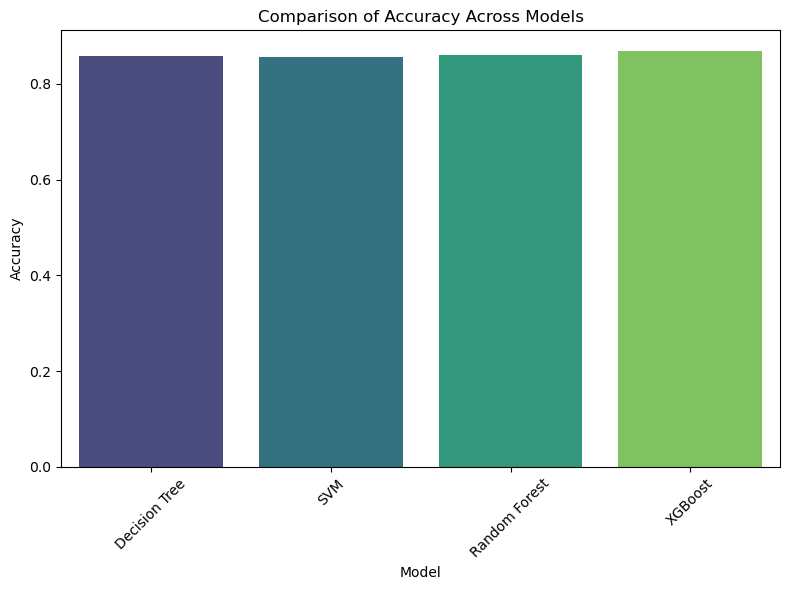

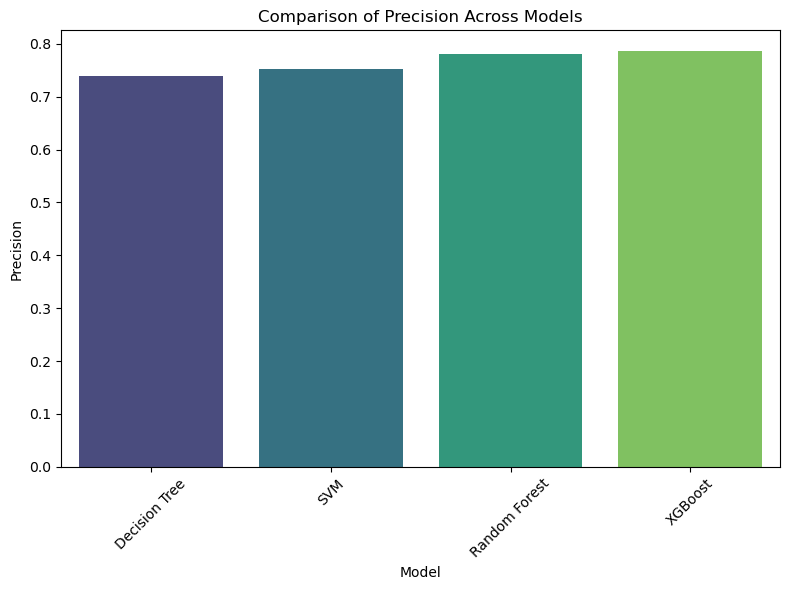

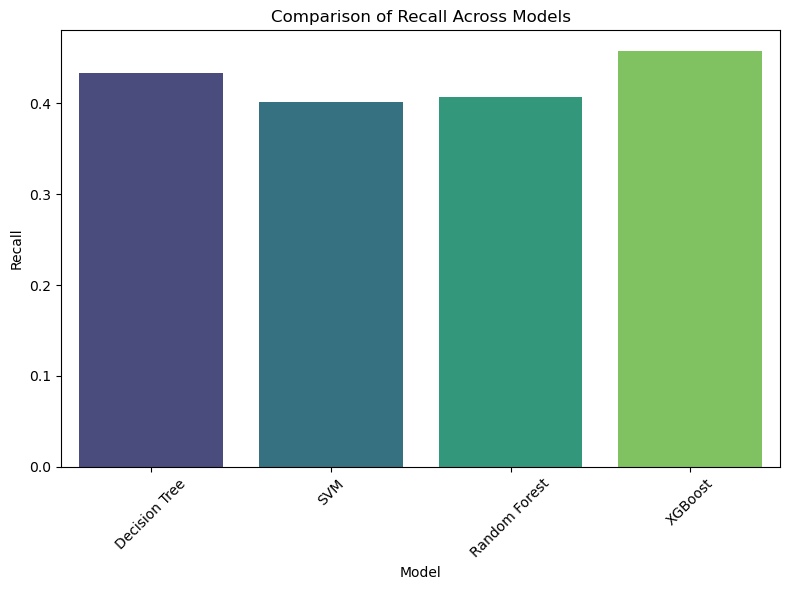

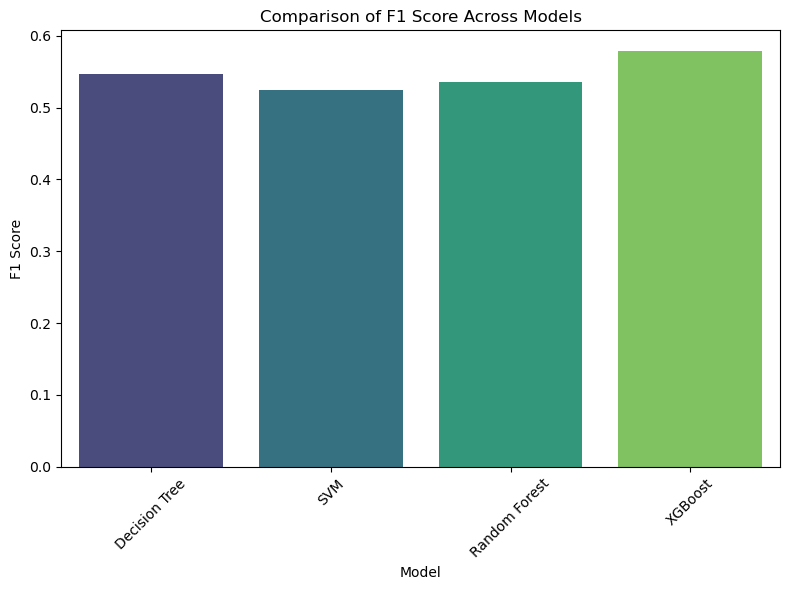

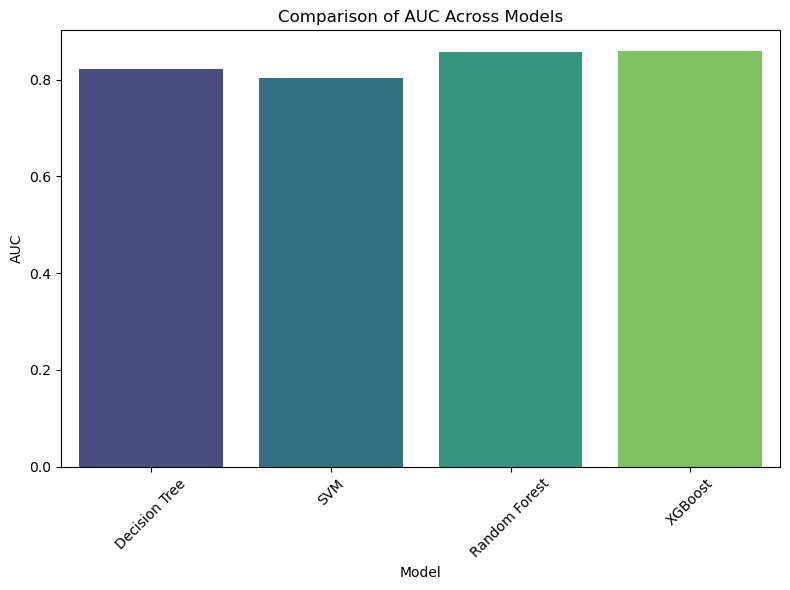

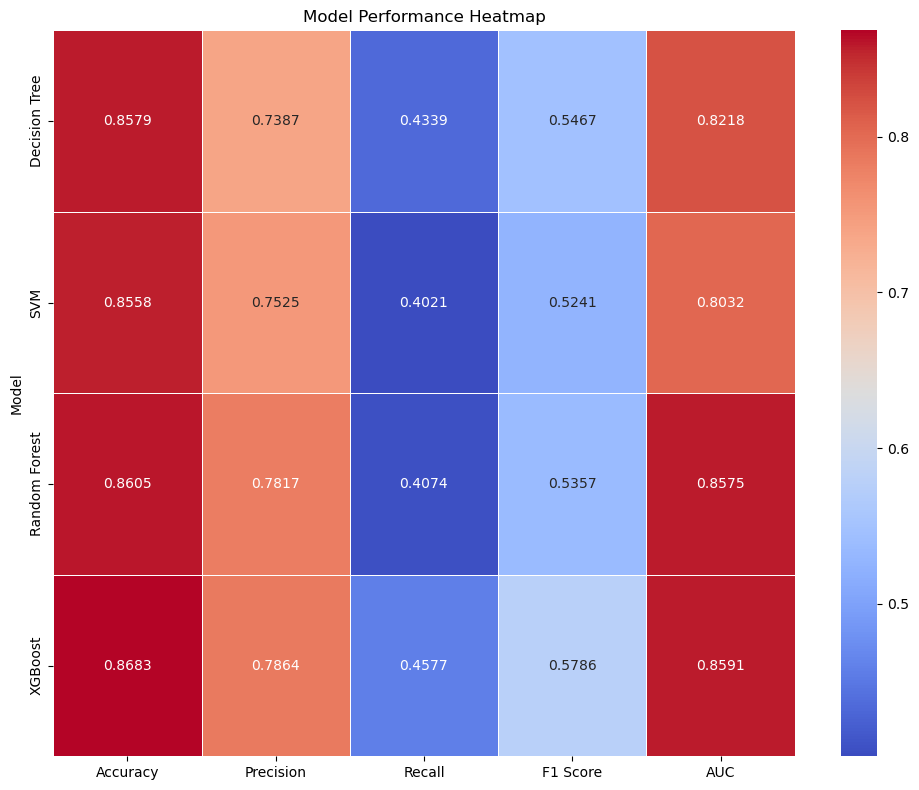

In [57]:
# Import necessary libraries
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For creating plots
import seaborn as sns  # For advanced visualization
import dataframe_image as dfi  # For saving styled DataFrame as an image

# Load results from the CSV file
results_csv_path = r"C:\Nauka\Studia\3 semestr\AI\Bank Customer Churn Dataset\model_results.csv"
results_df = pd.read_csv(results_csv_path)  # Load the results into a DataFrame

# Adjust index to start from 1
results_df.index = results_df.index + 1  # Change index to start from 1 instead of 0

# Enhanced console output with visual style
print("=" * 60)  # Print a decorative line
print("                     MODEL RESULTS                     ")  # Title for the results
print("=" * 60)  # Print another decorative line

# Style the table using pandas for a visually appealing output
styled_table = (
    results_df.style
    .set_table_styles(  # Set custom styles for the table
        [
            {'selector': 'thead th', 'props': [('background-color', '#e0e0e0'),  # Light gray header background
                                               ('font-weight', 'bold'),         # Bold header text
                                               ('text-align', 'center')]},      # Centered header text
            {'selector': 'tbody td', 'props': [('border', '1px solid #d3d3d3'),  # Light gray cell border
                                               ('text-align', 'center')]}       # Centered cell text
        ]
    )
    .format("{:.4f}", subset=["Accuracy", "Precision", "Recall", "F1 Score", "AUC"])  # Format numerical values to 4 decimals
)

# Display the styled table (works in Jupyter Notebook or compatible environments)
try:
    from IPython.display import display  # Import display for rendering styled tables
    display(styled_table)  # Show the styled table
except ImportError:
    print("Styled table can only be rendered in Jupyter or compatible environments.")

# Save the styled table as an image
table_path = r"C:\Nauka\Studia\3 semestr\AI\Bank Customer Churn Dataset\model_results_table.png"
dfi.export(styled_table, table_path)  # Save the styled table as a PNG image

# Plot metrics for each model
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"]  # Metrics to visualize

for metric in metrics:
    plt.figure(figsize=(8, 6))  # Set figure size
    sns.barplot(x="Model", y=metric, data=results_df, palette="viridis", hue="Model", dodge=False)  # Create bar plot
    plt.title(f"Comparison of {metric} Across Models")  # Set plot title
    plt.ylabel(metric)  # Label for the y-axis
    plt.xlabel("Model")  # Label for the x-axis
    plt.legend([], [], frameon=False)  # Remove legend for cleaner visualization
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent overlaps
    plot_path = f"C:\\Nauka\\Studia\\3 semestr\\AI\\Bank Customer Churn Dataset\\{metric.lower()}_comparison.png"
    plt.savefig(plot_path)  # Save the plot as a PNG file
    plt.show()  # Display the plot

# Generate heatmap for all metrics
plt.figure(figsize=(10, 8))  # Set figure size for the heatmap
heatmap_data = results_df.set_index("Model")[metrics]  # Set 'Model' as the index for better heatmap display
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="coolwarm", linewidths=0.5, cbar=True)  # Create heatmap
plt.title("Model Performance Heatmap")  # Set heatmap title
plt.tight_layout()  # Adjust layout to prevent overlaps
heatmap_path = r"C:\Nauka\Studia\3 semestr\AI\Bank Customer Churn Dataset\model_performance_heatmap.png"
plt.savefig(heatmap_path)  # Save the heatmap as a PNG file
plt.show()  # Display the heatmap
